In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import transforms, models
from skimage.metrics import structural_similarity as ssim
from torchmetrics.image.fid import FrechetInceptionDistance  # To calculate FID
from torch.nn.functional import mse_loss

# Load the .npy files
train_input = np.load('data(processed)/train_input.npy').astype(np.float32)  # Convert to float32
train_output = np.load('data(processed)/train_output.npy').astype(np.float32)  # Convert to float32
val_input = np.load('data(processed)/val_input.npy').astype(np.float32)
val_output = np.load('data(processed)/val_output.npy').astype(np.float32)
test_input = np.load('data(processed)/test_input.npy').astype(np.float32)
test_output = np.load('data(processed)/test_output.npy').astype(np.float32)

# Custom Dataset Class
class MRICTDataset(Dataset):
    def __init__(self, input_data, output_data, transform=None):
        self.input_data = input_data
        self.output_data = output_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        # Load MRI and CT images
        mri_image = self.input_data[idx]
        ct_image = self.output_data[idx]

        # Convert to 3-channel images
        mri_image = np.repeat(mri_image[np.newaxis, :, :], 3, axis=0)  # Repeat for 3 channels
        ct_image = np.repeat(ct_image[np.newaxis, :, :], 3, axis=0)  # Repeat for 3 channels

        if self.transform:
            mri_image = torch.tensor(mri_image)  # Convert to tensor
            ct_image = torch.tensor(ct_image)  # Convert to tensor

            mri_image = self.transform(mri_image)  # Transform MRI
            ct_image = self.transform(ct_image)  # Transform CT

        return mri_image, ct_image

# Data transformation with augmentation
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.float()),  # Ensure tensor is float type
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize for 3 channels
    transforms.RandomHorizontalFlip(),  # Random horizontal flip for data augmentation
    transforms.RandomVerticalFlip(),  # Random vertical flip for data augmentation
])

# Create Dataset and DataLoader
train_dataset = MRICTDataset(train_input, train_output, transform=transform)
val_dataset = MRICTDataset(val_input, val_output, transform=transform)
test_dataset = MRICTDataset(test_input, test_output, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Changed batch size to 16
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Changed batch size to 16
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Changed batch size to 16

# Print counts and sizes
print(f'Training set: {len(train_dataset)} pairs, Size: {train_input.shape} (input), {train_output.shape} (output)')
print(f'Validation set: {len(val_dataset)} pairs, Size: {val_input.shape} (input), {val_output.shape} (output)')
print(f'Testing set: {len(test_dataset)} pairs, Size: {test_input.shape} (input), {test_output.shape} (output)')

# Check image sizes and uniformity
def check_image_sizes(dataset, name):
    # Get the size of the first image
    first_input_size = dataset.input_data[0].shape
    first_output_size = dataset.output_data[0].shape
    
    # Check if all images have the same size
    all_inputs_same_size = all(img.shape == first_input_size for img in dataset.input_data)
    all_outputs_same_size = all(img.shape == first_output_size for img in dataset.output_data)

    print(f"{name} set:")
    print(f" - First MRI image size: {first_input_size}")
    print(f" - First CT image size: {first_output_size}")
    print(f" - All MRI images same size: {all_inputs_same_size}")
    print(f" - All CT images same size: {all_outputs_same_size}\n")

# Check sizes for training, validation, and testing datasets
check_image_sizes(train_dataset, "Training")
check_image_sizes(val_dataset, "Validation")
check_image_sizes(test_dataset, "Testing")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Define device

Training set: 570 pairs, Size: (570, 256, 256) (input), (570, 256, 256) (output)
Validation set: 90 pairs, Size: (90, 256, 256) (input), (90, 256, 256) (output)
Testing set: 150 pairs, Size: (150, 256, 256) (input), (150, 256, 256) (output)
Training set:
 - First MRI image size: (256, 256)
 - First CT image size: (256, 256)
 - All MRI images same size: True
 - All CT images same size: True

Validation set:
 - First MRI image size: (256, 256)
 - First CT image size: (256, 256)
 - All MRI images same size: True
 - All CT images same size: True

Testing set:
 - First MRI image size: (256, 256)
 - First CT image size: (256, 256)
 - All MRI images same size: True
 - All CT images same size: True



..................[Epoch 1/20] [Batch 18/36] [D Loss: 9.728048] [G Loss: 8.196319] [GAN Loss: 1.072190] [Perceptual Loss: 0.158314] [D Real Acc: 0.750000] [D Fake Acc: 1.000000] [D Avg Acc: 0.875000]
..................[Epoch 1/20] [Batch 36/36] [D Loss: 9.459144] [G Loss: 7.777390] [GAN Loss: 1.438081] [Perceptual Loss: 0.140874] [D Real Acc: 0.600000] [D Fake Acc: 1.000000] [D Avg Acc: 0.800000]
Validation -> 
[Epoch 1/20] Validation Metrics: MSE: 0.730154, SSIM: -0.000161, FID: 228.725665, VGG Loss: 0.193569
..................[Epoch 2/20] [Batch 18/36] [D Loss: 9.519293] [G Loss: 6.413454] [GAN Loss: 1.077019] [Perceptual Loss: 0.118587] [D Real Acc: 0.187500] [D Fake Acc: 1.000000] [D Avg Acc: 0.593750]
..................[Epoch 2/20] [Batch 36/36] [D Loss: 9.139315] [G Loss: 5.727872] [GAN Loss: 0.982963] [Perceptual Loss: 0.105442] [D Real Acc: 0.700000] [D Fake Acc: 1.000000] [D Avg Acc: 0.850000]
Validation -> 
[Epoch 2/20] Validation Metrics: MSE: 0.794150, SSIM: 0.000022, FID: 

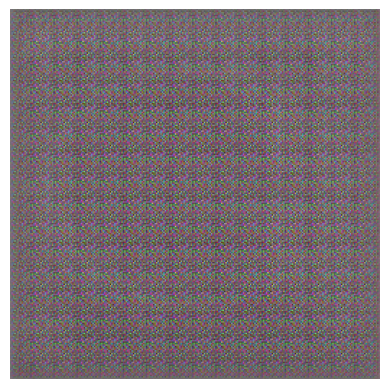

In [2]:
# Define UNet Generator
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        # Encoder
        self.enc1 = self.encoder_block(3, 64)
        self.enc2 = self.encoder_block(64, 128)
        self.enc3 = self.encoder_block(128, 256)
        self.enc4 = self.encoder_block(256, 512)

        # Bottleneck
        self.bottleneck = self.encoder_block(512, 512)

        # Decoder
        self.dec4 = self.decoder_block(512, 256)
        self.dec3 = self.decoder_block(512 + 256, 128)
        self.dec2 = self.decoder_block(256 + 128, 64)
        self.dec1 = nn.ConvTranspose2d(192, 64, kernel_size=4, stride=2, padding=1)
        self.final_upsample = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()  # Using Tanh for final output

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.15),
            nn.Dropout(p=0.1)  # Reduced dropout to 0.2 in the generator
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.15),
            nn.Dropout(p=0.1)  # Reduced dropout to 0.2 in the generator
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        bottleneck = self.bottleneck(enc4)

        dec4 = self.dec4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec3 = self.dec3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec2 = self.dec2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec1 = self.dec1(dec2)
        out = self.final_upsample(dec1)
        return self.tanh(out)  # Use tanh for output

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.38),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.38),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.38),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.38),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)  # Output shape: [batch_size, 1, 1, 1]
        )

        # Global Average Pooling to get single scalar value
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.sigmoid = nn.Sigmoid()  # Add Sigmoid layer

    def forward(self, x):
        out = self.model(x)
        out = self.global_avg_pool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)  # Flatten to [batch_size, 1]
        out = self.sigmoid(out)  # Apply Sigmoid
        return out

# Loss functions
criterion_GAN = nn.BCELoss()  # GAN loss
criterion_pixelwise = nn.L1Loss()  # L1 loss
vgg = models.vgg19(weights='DEFAULT').features.eval().to(device)  # Pre-trained VGG for perceptual loss

# Frechet Inception Distance (FID) for validation
fid_metric = FrechetInceptionDistance().to(device)

# Custom perceptual loss function
def perceptual_loss(y_true, y_pred):
    # Compute the VGG features
    y_true_features = vgg(y_true)
    y_pred_features = vgg(y_pred)
    return nn.functional.mse_loss(y_pred_features, y_true_features)  # Use MSE for feature loss

# Function to compute gradient penalty
def compute_gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)
    # Generate random weight for interpolation
    alpha = torch.rand(batch_size, 1, 1, 1).to(real_images.device)
    # Interpolate between real and fake images
    interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
    
    # Get discriminator output for interpolated images
    d_interpolates = discriminator(interpolates)
    
    # Compute gradients of the output with respect to the interpolated images
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute the L2 norm of the gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Hyperparameter for balancing losses
lambda_l1 = 45  # Decreased lambda_l1
lambda_gp = 10  # Weight for gradient penalty

# Early stopping variables
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# Initialize models
generator = UNetGenerator().to(device)
discriminator = Discriminator(in_channels=3).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.000045, betas=(0.5, 0.999))  # Updated D learning rate

# Learning rate scheduler with patience
scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=5)
scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=5)

# Validation function to calculate metrics
def validate(generator, val_loader):
    generator.eval()  # Set to evaluation mode
    total_mse, total_ssim, total_fid, total_vgg_loss = 0, 0, 0, 0
    fid_metric.reset()  # Reset FID metric

    with torch.no_grad():
        for mri_images, ct_images in val_loader:
            mri_images, ct_images = mri_images.to(device), ct_images.to(device)

            # Generate CT images from MRI
            fake_ct_images = generator(mri_images)

            # MSE
            mse = mse_loss(fake_ct_images, ct_images).item()
            total_mse += mse

            # SSIM
            ssim_val = 0
            for i in range(fake_ct_images.shape[0]):
                # Adjusting SSIM calculation
                ssim_val += ssim(fake_ct_images[i].cpu().numpy(), ct_images[i].cpu().numpy(), 
                                  multichannel=True, win_size=3, data_range=1)  # Added data_range
            ssim_val /= fake_ct_images.shape[0]
            total_ssim += ssim_val

            # FID
            # Convert to [0, 255] range and to uint8
            fake_ct_images_uint8 = ((fake_ct_images + 1) * 127.5).clamp(0, 255).byte()
            ct_images_uint8 = ((ct_images + 1) * 127.5).clamp(0, 255).byte()
            
            fid_metric.update(fake_ct_images_uint8, real=True)
            fid_metric.update(ct_images_uint8, real=False)
            fid_value = fid_metric.compute().item()
            total_fid += fid_value

            # Perceptual Loss (VGG loss)
            vgg_loss_value = perceptual_loss(ct_images, fake_ct_images).item()
            total_vgg_loss += vgg_loss_value

    # Average the metrics over validation set
    avg_mse = total_mse / len(val_loader)
    avg_ssim = total_ssim / len(val_loader)
    avg_fid = total_fid / len(val_loader)
    avg_vgg_loss = total_vgg_loss / len(val_loader)

    return avg_mse, avg_ssim, avg_fid, avg_vgg_loss

# Function to train the Pix2Pix model with early stopping
def train_pix2pix(generator, discriminator, train_loader, val_loader, num_epochs):
    global best_val_loss, epochs_no_improve
    generator.train()  # Set generator to training mode
    discriminator.train()  # Set discriminator to training mode
    
    for epoch in range(num_epochs):
        for i, (mri_images, ct_images) in enumerate(train_loader):
            mri_images, ct_images = mri_images.to(device), ct_images.to(device)

            # Labels for GAN
            valid = torch.ones(mri_images.size(0), 1, device=device) * 0.85  # Real labels with label smoothing
            fake = torch.zeros(mri_images.size(0), 1, device=device)  # Fake labels

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = criterion_GAN(discriminator(ct_images), valid)  # Real loss
            fake_images = generator(mri_images)
            fake_loss = criterion_GAN(discriminator(fake_images.detach()), fake)  # Fake loss
            gradient_penalty = compute_gradient_penalty(discriminator, ct_images, fake_images.detach())
            d_loss = (real_loss + fake_loss) / 2 + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizer_D.step()

            # Calculate discriminator accuracy
            D_real_acc = (discriminator(ct_images) > 0.5).float().mean().item()  # Accuracy on real images
            D_fake_acc = (discriminator(fake_images.detach()) < 0.5).float().mean().item()  # Accuracy on fake images
            D_avg_acc = (D_real_acc + D_fake_acc) / 2  # Average accuracy

            # Train Generator (3 times for every 1 update of the discriminator)
            for _ in range(2):
                optimizer_G.zero_grad()
                # Detach discriminator output to avoid gradient computation
                fake_images = generator(mri_images)  # Regenerate fake images inside loop
                disc_output = discriminator(fake_images)
                loss_GAN = criterion_GAN(disc_output, valid)  # GAN loss
                loss_pixel = perceptual_loss(fake_images, ct_images)  # Use perceptual loss
                loss_G = loss_GAN + lambda_l1 * loss_pixel  # Total loss
                loss_G.backward()  # Remove retain_graph=True
                optimizer_G.step()

            # Print detailed losses and accuracies
            print(".", end="")
            if (i + 1) % 18 == 0:  # Change to every 10 batches
                print(f"[Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(train_loader)}] "
                      f"[D Loss: {d_loss.item():.6f}] [G Loss: {loss_G.item():.6f}] "
                      f"[GAN Loss: {loss_GAN.item():.6f}] [Perceptual Loss: {loss_pixel.item():.6f}] "
                      f"[D Real Acc: {D_real_acc:.6f}] [D Fake Acc: {D_fake_acc:.6f}] "
                      f"[D Avg Acc: {D_avg_acc:.6f}]")

        # Validation after each epoch
        val_mse, val_ssim, val_fid, val_vgg_loss = validate(generator, val_loader)

        # Log validation metrics
        print("Validation -> ", end="")
        print(f"\n[Epoch {epoch + 1}/{num_epochs}] Validation Metrics: "
              f"MSE: {val_mse:.6f}, SSIM: {val_ssim:.6f}, FID: {val_fid:.6f}, VGG Loss: {val_vgg_loss:.6f}")

        # Early stopping logic
        total_val_loss = val_mse + val_fid + val_vgg_loss
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            epochs_no_improve = 0
            torch.save(generator.state_dict(), 'best_generator.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break
            
        # Adjust learning rates using scheduler
        scheduler_G.step(loss_G)
        scheduler_D.step(d_loss)

# Train the model
train_pix2pix(generator, discriminator, train_loader, val_loader, num_epochs=20)

# Save the final models
torch.save(generator.state_dict(), 'final_generator.pth')
torch.save(discriminator.state_dict(), 'final_discriminator.pth')

# Plotting a sample output after training
generator.eval()  # Set to evaluation mode
with torch.no_grad():
    sample_mri = torch.tensor(val_input[0]).unsqueeze(0).to(device)  # Get the first validation MRI
    sample_mri = sample_mri.repeat(1, 3, 1, 1)  # Repeat for 3 channels
    generated_ct = generator(sample_mri)  # Generate CT from MRI

# Convert back to numpy for plotting
generated_ct_np = generated_ct.squeeze().cpu().numpy().transpose(1, 2, 0)  # Change dimensions for plotting
plt.imshow((generated_ct_np + 1) / 2)  # Rescale from [-1, 1] to [0, 1]
plt.axis('off')
plt.show()


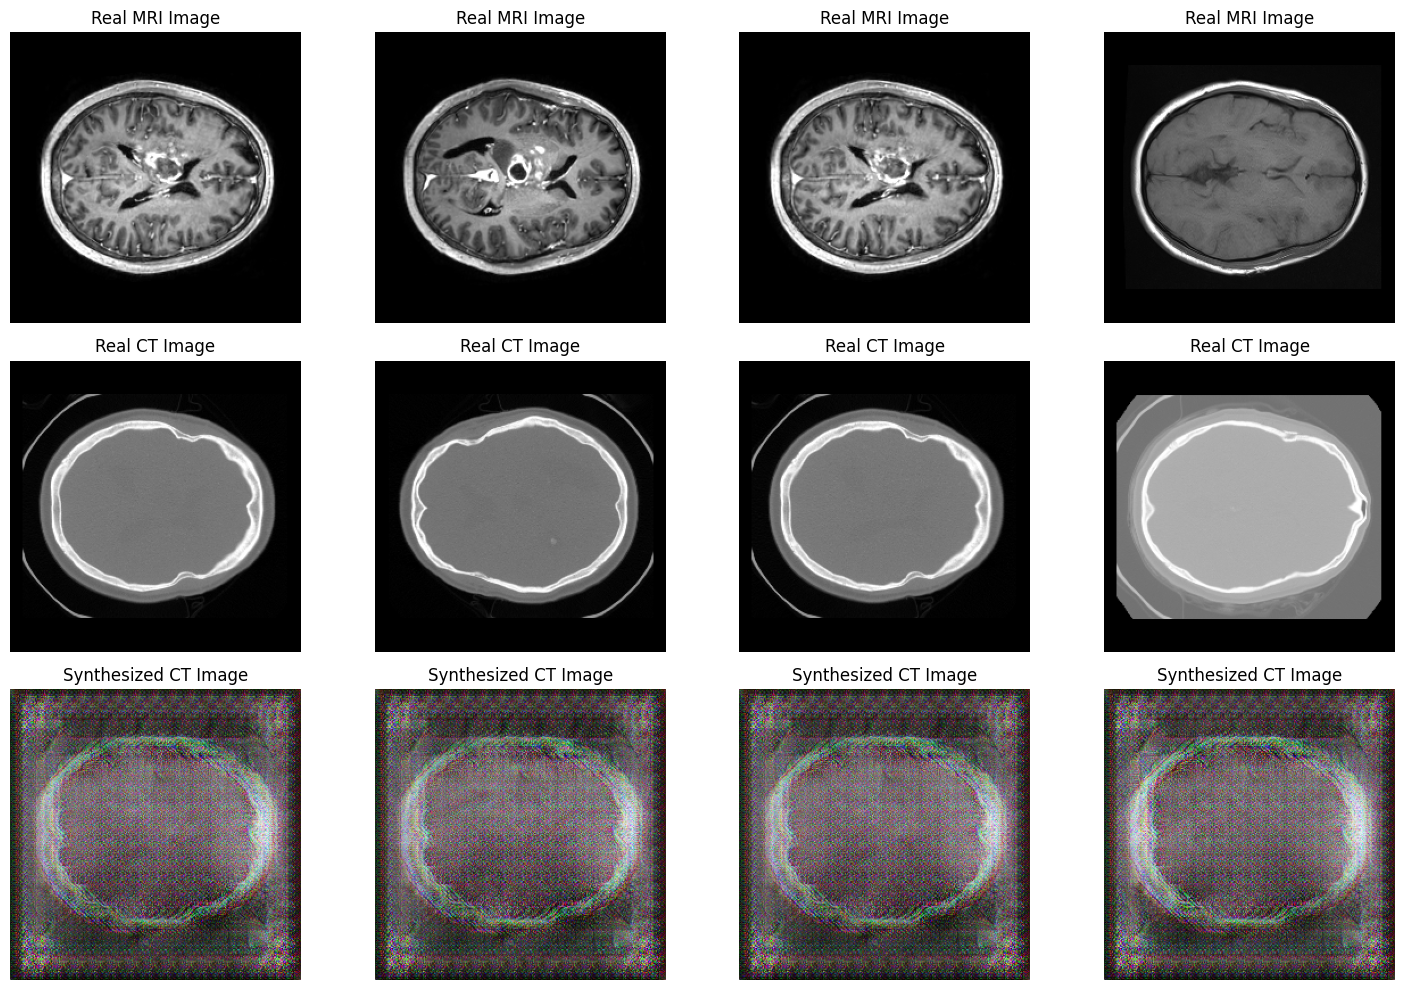

In [4]:
import random

# Function to visualize real and synthesized images
def visualize_results(generator, test_loader):
    generator.eval()
    with torch.no_grad():
        # Select 4 random images from the test dataset
        sample_indices = random.sample(range(len(test_loader.dataset)), 4)
        
        plt.figure(figsize=(15, 10))
        for idx, i in enumerate(sample_indices):
            mri_image, ct_image = test_loader.dataset[i]  # Get the MRI and CT images
            mri_image = mri_image.unsqueeze(0).to(device)  # Add batch dimension and move to device
            generated_image = generator(mri_image).squeeze(0)  # Generate synthetic CT and remove batch dimension

            # Convert images to [0, 1] range for visualization
            mri_image = (mri_image + 1) / 2  # Rescale from [-1, 1] to [0, 1]
            ct_image = (ct_image + 1) / 2  # Rescale from [-1, 1] to [0, 1]
            generated_image = (generated_image + 1) / 2  # Rescale from [-1, 1] to [0, 1]

            # Plot MRI Image
            plt.subplot(3, 4, idx + 1)
            plt.imshow(mri_image.cpu().squeeze().permute(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.title('Real MRI Image')

            # Plot CT Image
            plt.subplot(3, 4, idx + 5)
            plt.imshow(ct_image.cpu().squeeze().permute(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.title('Real CT Image')

            # Plot Generated CT Image
            plt.subplot(3, 4, idx + 9)
            plt.imshow(generated_image.cpu().squeeze().permute(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.title('Synthesized CT Image')
        
        plt.tight_layout()
        plt.show()


# Call the visualization function
visualize_results(generator, test_loader)


# Model MK 4

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchvision import transforms, models
from skimage.metrics import structural_similarity as ssim
from torchmetrics.image.fid import FrechetInceptionDistance  # To calculate FID
from torch.nn.functional import mse_loss

# Load the .npy files
train_input = np.load('data(processed)/train_input.npy').astype(np.float32)  # Convert to float32
train_output = np.load('data(processed)/train_output.npy').astype(np.float32)  # Convert to float32
val_input = np.load('data(processed)/val_input.npy').astype(np.float32)
val_output = np.load('data(processed)/val_output.npy').astype(np.float32)
test_input = np.load('data(processed)/test_input.npy').astype(np.float32)
test_output = np.load('data(processed)/test_output.npy').astype(np.float32)

# Custom Dataset Class
class MRICTDataset(Dataset):
    def __init__(self, input_data, output_data, transform=None):
        self.input_data = input_data
        self.output_data = output_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        # Load MRI and CT images
        mri_image = self.input_data[idx]
        ct_image = self.output_data[idx]

        # Convert to 3-channel images
        mri_image = np.repeat(mri_image[np.newaxis, :, :], 3, axis=0)  # Repeat for 3 channels
        ct_image = np.repeat(ct_image[np.newaxis, :, :], 3, axis=0)  # Repeat for 3 channels

        if self.transform:
            mri_image = torch.tensor(mri_image)  # Convert to tensor
            ct_image = torch.tensor(ct_image)  # Convert to tensor

            mri_image = self.transform(mri_image)  # Transform MRI
            ct_image = self.transform(ct_image)  # Transform CT

        return mri_image, ct_image

# Data transformation with augmentation
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.float()),  # Ensure tensor is float type
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize for 3 channels
    transforms.RandomHorizontalFlip(),  # Random horizontal flip for data augmentation
    transforms.RandomVerticalFlip(),  # Random vertical flip for data augmentation
])

# Create Dataset and DataLoader
train_dataset = MRICTDataset(train_input, train_output, transform=transform)
val_dataset = MRICTDataset(val_input, val_output, transform=transform)
test_dataset = MRICTDataset(test_input, test_output, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Changed batch size to 16
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # Changed batch size to 16
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Changed batch size to 16

# Print counts and sizes
print(f'Training set: {len(train_dataset)} pairs, Size: {train_input.shape} (input), {train_output.shape} (output)')
print(f'Validation set: {len(val_dataset)} pairs, Size: {val_input.shape} (input), {val_output.shape} (output)')
print(f'Testing set: {len(test_dataset)} pairs, Size: {test_input.shape} (input), {test_output.shape} (output)')

# Check image sizes and uniformity
def check_image_sizes(dataset, name):
    # Get the size of the first image
    first_input_size = dataset.input_data[0].shape
    first_output_size = dataset.output_data[0].shape
    
    # Check if all images have the same size
    all_inputs_same_size = all(img.shape == first_input_size for img in dataset.input_data)
    all_outputs_same_size = all(img.shape == first_output_size for img in dataset.output_data)

    print(f"{name} set:")
    print(f" - First MRI image size: {first_input_size}")
    print(f" - First CT image size: {first_output_size}")
    print(f" - All MRI images same size: {all_inputs_same_size}")
    print(f" - All CT images same size: {all_outputs_same_size}\n")

# Check sizes for training, validation, and testing datasets
check_image_sizes(train_dataset, "Training")
check_image_sizes(val_dataset, "Validation")
check_image_sizes(test_dataset, "Testing")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Define device

In [ ]:
# MK 4 = MK 3 + 0.33 D dropout , D lr = 0.000055 + GAN loss * 1.5

# Define UNet Generator
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        # Encoder
        self.enc1 = self.encoder_block(3, 64)
        self.enc2 = self.encoder_block(64, 128)
        self.enc3 = self.encoder_block(128, 256)
        self.enc4 = self.encoder_block(256, 512)

        # Bottleneck
        self.bottleneck = self.encoder_block(512, 512)

        # Decoder
        self.dec4 = self.decoder_block(512, 256)
        self.dec3 = self.decoder_block(512 + 256, 128)
        self.dec2 = self.decoder_block(256 + 128, 64)
        self.dec1 = nn.ConvTranspose2d(192, 64, kernel_size=4, stride=2, padding=1)
        self.final_upsample = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()  # Using Tanh for final output

    def encoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.18),
            nn.Dropout(p=0.1)  # Reduced dropout to 0.2 in the generator
        )

    def decoder_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.18),
            nn.Dropout(p=0.1)  # Reduced dropout to 0.2 in the generator
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        bottleneck = self.bottleneck(enc4)

        dec4 = self.dec4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec3 = self.dec3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec2 = self.dec2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec1 = self.dec1(dec2)
        out = self.final_upsample(dec1)
        return self.tanh(out)  # Use tanh for output

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.33),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.33),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.33),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.33),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)  # Output shape: [batch_size, 1, 1, 1]
        )

        # Global Average Pooling to get single scalar value
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.sigmoid = nn.Sigmoid()  # Add Sigmoid layer

    def forward(self, x):
        out = self.model(x)
        out = self.global_avg_pool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)  # Flatten to [batch_size, 1]
        out = self.sigmoid(out)  # Apply Sigmoid
        return out

# Loss functions
criterion_GAN = nn.BCELoss()  # GAN loss
criterion_pixelwise = nn.L1Loss()  # L1 loss
vgg = models.vgg19(weights='DEFAULT').features.eval().to(device)  # Pre-trained VGG for perceptual loss

# Frechet Inception Distance (FID) for validation
fid_metric = FrechetInceptionDistance().to(device)

# Custom perceptual loss function
def perceptual_loss(y_true, y_pred):
    # Compute the VGG features
    y_true_features = vgg(y_true)
    y_pred_features = vgg(y_pred)
    return nn.functional.mse_loss(y_pred_features, y_true_features)  # Use MSE for feature loss

# Function to compute gradient penalty
def compute_gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)
    # Generate random weight for interpolation
    alpha = torch.rand(batch_size, 1, 1, 1).to(real_images.device)
    # Interpolate between real and fake images
    interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
    
    # Get discriminator output for interpolated images
    d_interpolates = discriminator(interpolates)
    
    # Compute gradients of the output with respect to the interpolated images
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute the L2 norm of the gradients
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Hyperparameter for balancing losses
lambda_l1 = 45  # Decreased lambda_l1
lambda_gp = 10  # Weight for gradient penalty

# Early stopping variables
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0

# Initialize models
generator = UNetGenerator().to(device)
discriminator = Discriminator(in_channels=3).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.000055, betas=(0.5, 0.999))  # Updated D learning rate

# Learning rate scheduler with patience
scheduler_G = optim.lr_scheduler.ReduceLROnPlateau(optimizer_G, mode='min', factor=0.5, patience=5)
scheduler_D = optim.lr_scheduler.ReduceLROnPlateau(optimizer_D, mode='min', factor=0.5, patience=5)

# Validation function to calculate metrics
def validate(generator, val_loader):
    generator.eval()  # Set to evaluation mode
    total_mse, total_ssim, total_fid, total_vgg_loss = 0, 0, 0, 0
    fid_metric.reset()  # Reset FID metric

    with torch.no_grad():
        for mri_images, ct_images in val_loader:
            mri_images, ct_images = mri_images.to(device), ct_images.to(device)

            # Generate CT images from MRI
            fake_ct_images = generator(mri_images)

            # MSE
            mse = mse_loss(fake_ct_images, ct_images).item()
            total_mse += mse

            # SSIM
            ssim_val = 0
            for i in range(fake_ct_images.shape[0]):
                # Adjusting SSIM calculation
                ssim_val += ssim(fake_ct_images[i].cpu().numpy(), ct_images[i].cpu().numpy(), 
                                  multichannel=True, win_size=3, data_range=1)  # Added data_range
            ssim_val /= fake_ct_images.shape[0]
            total_ssim += ssim_val

            # FID
            # Convert to [0, 255] range and to uint8
            fake_ct_images_uint8 = ((fake_ct_images + 1) * 127.5).clamp(0, 255).byte()
            ct_images_uint8 = ((ct_images + 1) * 127.5).clamp(0, 255).byte()
            
            fid_metric.update(fake_ct_images_uint8, real=True)
            fid_metric.update(ct_images_uint8, real=False)
            fid_value = fid_metric.compute().item()
            total_fid += fid_value

            # Perceptual Loss (VGG loss)
            vgg_loss_value = perceptual_loss(ct_images, fake_ct_images).item()
            total_vgg_loss += vgg_loss_value

    # Average the metrics over validation set
    avg_mse = total_mse / len(val_loader)
    avg_ssim = total_ssim / len(val_loader)
    avg_fid = total_fid / len(val_loader)
    avg_vgg_loss = total_vgg_loss / len(val_loader)

    return avg_mse, avg_ssim, avg_fid, avg_vgg_loss

# Function to train the Pix2Pix model with early stopping
def train_pix2pix(generator, discriminator, train_loader, val_loader, num_epochs):
    global best_val_loss, epochs_no_improve
    generator.train()  # Set generator to training mode
    discriminator.train()  # Set discriminator to training mode
    
    for epoch in range(num_epochs):
        for i, (mri_images, ct_images) in enumerate(train_loader):
            mri_images, ct_images = mri_images.to(device), ct_images.to(device)

            # Labels for GAN
            valid = torch.ones(mri_images.size(0), 1, device=device) * 0.9  # Real labels with label smoothing
            fake = torch.zeros(mri_images.size(0), 1, device=device) * 0.95 # Fake labels

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = criterion_GAN(discriminator(ct_images), valid)  # Real loss
            fake_images = generator(mri_images)
            fake_loss = criterion_GAN(discriminator(fake_images.detach()), fake)  # Fake loss
            gradient_penalty = compute_gradient_penalty(discriminator, ct_images, fake_images.detach())
            d_loss = (real_loss + fake_loss) / 2 + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizer_D.step()

            # Calculate discriminator accuracy
            D_real_acc = (discriminator(ct_images) > 0.5).float().mean().item()  # Accuracy on real images
            D_fake_acc = (discriminator(fake_images.detach()) < 0.5).float().mean().item()  # Accuracy on fake images
            D_avg_acc = (D_real_acc + D_fake_acc) / 2  # Average accuracy

            # Train Generator (3 times for every 1 update of the discriminator)
            for _ in range(2):
                optimizer_G.zero_grad()
                # Detach discriminator output to avoid gradient computation
                fake_images = generator(mri_images)  # Regenerate fake images inside loop
                disc_output = discriminator(fake_images)
                loss_GAN = criterion_GAN(disc_output, valid)  # GAN loss
                loss_pixel = perceptual_loss(fake_images, ct_images)  # Use perceptual loss
                loss_G = 1.5*loss_GAN + lambda_l1 * loss_pixel  # Total loss
                loss_G.backward()  # Remove retain_graph=True
                optimizer_G.step()

            # Print detailed losses and accuracies
            print(".", end="")
            if (i + 1) % 36 == 0:  # Change to every 10 batches
                print(f"[Epoch {epoch + 1}/{num_epochs}] [Batch {i + 1}/{len(train_loader)}] "
                      f"[D Loss: {d_loss.item():.6f}] [G Loss: {loss_G.item():.6f}] "
                      f"[GAN Loss: {loss_GAN.item():.6f}] [Perceptual Loss: {loss_pixel.item():.6f}] "
                      f"[D Real Acc: {D_real_acc:.6f}] [D Fake Acc: {D_fake_acc:.6f}] "
                      f"[D Avg Acc: {D_avg_acc:.6f}]")

        # Validation after each epoch
        val_mse, val_ssim, val_fid, val_vgg_loss = validate(generator, val_loader)

        # Log validation metrics
        print("Validation -> ", end="")
        print(f"\n[Epoch {epoch + 1}/{num_epochs}] Validation Metrics: "
              f"MSE: {val_mse:.6f}, SSIM: {val_ssim:.6f}, FID: {val_fid:.6f}, VGG Loss: {val_vgg_loss:.6f}")

        # Early stopping logic
        total_val_loss = val_fid * 0.5 + val_vgg_loss * 0.5
        if total_val_loss < best_val_loss:
            best_val_loss = total_val_loss
            epochs_no_improve = 0
            torch.save(generator.state_dict(), 'best_generator.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break
            
        # Adjust learning rates using scheduler
        scheduler_G.step(val_fid + val_vgg_loss)
        scheduler_D.step(d_loss)

# Train the model
train_pix2pix(generator, discriminator, train_loader, val_loader, num_epochs=60)

# Save the final models
torch.save(generator.state_dict(), 'final_generator.pth')
torch.save(discriminator.state_dict(), 'final_discriminator.pth')

# Plotting a sample output after training
generator.eval()  # Set to evaluation mode
with torch.no_grad():
    sample_mri = torch.tensor(val_input[0]).unsqueeze(0).to(device)  # Get the first validation MRI
    sample_mri = sample_mri.repeat(1, 3, 1, 1)  # Repeat for 3 channels
    generated_ct = generator(sample_mri)  # Generate CT from MRI

# Convert back to numpy for plotting
generated_ct_np = generated_ct.squeeze().cpu().numpy().transpose(1, 2, 0)  # Change dimensions for plotting
plt.imshow((generated_ct_np + 1) / 2)  # Rescale from [-1, 1] to [0, 1]
plt.axis('off')
plt.show()

In [ ]:
import random

# Function to visualize real and synthesized images
def visualize_results(generator, test_loader):
    generator.eval()
    with torch.no_grad():
        # Select 4 random images from the test dataset
        sample_indices = random.sample(range(len(test_loader.dataset)), 4)
        
        plt.figure(figsize=(15, 10))
        for idx, i in enumerate(sample_indices):
            mri_image, ct_image = test_loader.dataset[i]  # Get the MRI and CT images
            mri_image = mri_image.unsqueeze(0).to(device)  # Add batch dimension and move to device
            generated_image = generator(mri_image).squeeze(0)  # Generate synthetic CT and remove batch dimension

            # Convert images to [0, 1] range for visualization
            mri_image = (mri_image + 1) / 2  # Rescale from [-1, 1] to [0, 1]
            ct_image = (ct_image + 1) / 2  # Rescale from [-1, 1] to [0, 1]
            generated_image = (generated_image + 1) / 2  # Rescale from [-1, 1] to [0, 1]

            # Plot MRI Image
            plt.subplot(3, 4, idx + 1)
            plt.imshow(mri_image.cpu().squeeze().permute(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.title('Real MRI Image')

            # Plot CT Image
            plt.subplot(3, 4, idx + 5)
            plt.imshow(ct_image.cpu().squeeze().permute(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.title('Real CT Image')

            # Plot Generated CT Image
            plt.subplot(3, 4, idx + 9)
            plt.imshow(generated_image.cpu().squeeze().permute(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.title('Synthesized CT Image')
        
        plt.tight_layout()
        plt.show()


# Call the visualization function
visualize_results(generator, test_loader)